**Steady-State Energy Constrained Neural Networks (ECNN)**

This code develops steady-state ECNN models for the cases when *random bias with / without Gausssian noise* is added to true data to generate training data. The linear noise model works fine for all cases considered in this work. However, other parametric noise models can also be used.

The unconstrained network model is trained first, followed by the constrained model, i.e., ECNN. 
The optimal solution of the unconstrained network serve as initial guesses for the constrained formulation of the inverse problem.

Load the training and validation / simulation datasets and specify the input and output variables for the NN models. Note that the user can consider any steady-state dataset for training and validation. The rows signify the observation indices for steady-state data and the columns signify the input and output variables.

In [1]:
import numpy as np
import scipy as sp
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from idaes.core.solvers import get_solver
get_solver()
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import *
import math as mt
import time
import json
import pickle

In [2]:
# Loading the data for model development

data = pd.read_excel("Steady-State HX Data.xlsx","RandomBias+Gaussian Noise", header=None).values
data = data[2:, 1:]

# For this specific system, the first six columns are the model inputs and the following two columns are the model outputs
# The next two columns provide the specific heat values of flue gas and steam 

input_data = data[:,0:6]
output_data = data[:,6:8]

cp_data = data[:,8:10]

# Note that the base (truth) case, i.e., the tab named 'NoNoise' represents the dataset obtained from simulation of an appropriate first-principles
# model. It was also observed that the difference in heat (energy) balance for the 'True Data', i.e., the data containing no noise was not exactly
# zero in megawatts (MW) scale with respect to the superheater system. The corresponding difference in Q (MW) is also provided in the excel spreadsheet
# with respect to the true data obtained by simulation of the first-principles model. Although the specific formulation of the training and forward
# problems remain independent of the specfic types of constraints imposed, in this work, it is desired to see whether the ECNN converge at the 'True
# Data' considered even when trained with noisy transient data. Therefore, the corresponding constraint equations are modified to arrive at the 
# Delta_Q_True (MW) values calculated with respect to the 'True Data'.

heat_bal_st = data[:,10]

ni = input_data.shape[1]         # Number of inputs = Number of neurons in input layer
no = output_data.shape[1]        # Number of outputs = Number of neurons in output layer

# Default number of neurons in hidden layer taken equal to number of neurons in input layer. But it can be changed as needed.

nh = ni

nt = ni + no                     # Total number of variables

n = data.shape[0]                # Total number of datasets available for model development

In [3]:
# Defining the System Model in terms of Process Variables

# Lumped Parameter Model: Shell and Tube Heat Exchanger considering one grid (lumped). Mass is automatically conserved. Input variables include 
# the inlet flowrate, temperature and pressure of both steam and flue gas, while output variables consist of outlet temperature of both flue gas and
# steam

# Steady-state values for input and output variables

msteam_st = data[:,0] 
mfg_st = data[:,1]
Tsteam_in_st = data[:,2]
Tfg_in_st = data[:,3]
Psteam_in_st = data[:,4] 
Pfg_in_st = data[:,5]

Tsteam_out_st = data[:,6]
Tfg_out_st = data[:,7]

cpfg_st = data[:,8]
cpsteam_st = data[:,9]


In [4]:
# Data Preparation for Model Training

tn = int(0.7*n)                  # Selecting 70% of total data for training

# Normalization of model input and output variables
norm_mat = np.zeros((n, nt))
delta = np.zeros(nt)
for i in range(nt):
    delta[i] = np.max(data[:, i]) - np.min(data[:, i])
    norm_mat[:, i] = (data[:, i] - np.min(data[:, i])) / delta[i]  # Max-Min Normalization

Imat = norm_mat[:,0:ni].T
dsr = norm_mat[:,ni:nt].T

# Generating random training data for tn steps / indices
tr_steps = np.random.choice(n, tn, replace=False)
tr_steps = np.sort(tr_steps)

dsr_t = dsr[:, tr_steps-1]
Imat_t = Imat[:, tr_steps-1]
msteam_st_t = msteam_st[tr_steps-1]
mfg_st_t = mfg_st[tr_steps-1]
Tsteam_in_st_t = Tsteam_in_st[tr_steps-1]
Tfg_in_st_t = Tfg_in_st[tr_steps-1]
Psteam_in_st_t = Psteam_in_st[tr_steps-1]
Pfg_in_st_t = Pfg_in_st[tr_steps-1]
cpfg_st_t = cpfg_st[tr_steps-1]
cpsteam_st_t = cpsteam_st[tr_steps-1]
heat_bal_st_t = heat_bal_st[tr_steps-1]

**TRAINING (INVERSE PROBLEM) OF UNCONSTRAINED NEURAL NETWORKS** 

In [5]:
## Training of Unconstrained NN Model using Pyomo

## May use any NN library / package to train the unconstrained model

M = pyo.ConcreteModel()

M.I1 = pyo.RangeSet(1, ni)
M.I2 = pyo.RangeSet(1, nh)
M.I3 = pyo.RangeSet(1, no)
M.I4 = pyo.RangeSet(1, tn)

M.x1 = pyo.Var(M.I1,M.I2, bounds = (-0.5e1,0.5e1), initialize = 1e-1)                   # w_h (ANN)
M.x2 = pyo.Var(M.I2, bounds = (-0.5e1,0.5e1), initialize = 1e-1)                        # b_h (ANN)
M.x3 = pyo.Var(M.I2,M.I3,bounds = (-0.5e1,0.5e1), initialize = 1e-1)                    # w_o (ANN)
M.x4 = pyo.Var(M.I3, bounds = (-0.5e1,0.5e1), initialize = 1e-1)                        # b_o (ANN)

M.y1 = pyo.Var(M.I2,M.I4)                     # y_h (ANN)
M.y2 = pyo.Var(M.I3,M.I4)                     # y_ANN

def constraint_rule_1(M,i,j):
    return M.y1[i,j] == 1/(1 + pyo.exp(-sum((M.x1[k,i] * Imat_t[k-1,j-1]) for k in M.I1) + M.x2[i]))

M.constraint_1 = pyo.Constraint(M.I2, M.I4, rule = constraint_rule_1)         
    
def constraint_rule_2(M,i,j):
    return M.y2[i,j] == sum((M.x3[k,i] * M.y1[k,j]) for k in M.I2) + M.x4[i]

M.constraint_2 = pyo.Constraint(M.I3, M.I4, rule = constraint_rule_2)

def NN_unc_Obj(M):             
    obj_value = sum(sum((dsr_t[i-1,j-1] - M.y2[i,j]) ** 2 for i in M.I3) for j in M.I4)
    return obj_value

M.obj = pyo.Objective(rule = NN_unc_Obj, sense = pyo.minimize)

solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 1000

results = solver.solve(M, tee=True)

Ipopt 3.13.2: max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

In [6]:
## Accessing the optimal parameters of Unconstrained NN Model

w_h = np.zeros((ni,nh))
for (i,j) in M.x1:
    w_h[i-1,j-1] = pyo.value(M.x1[i,j])

b_h = np.zeros(nh)
for i in M.x2:
    b_h[i-1] = pyo.value(M.x2[i])

w_o = np.zeros((nh,no))
for (i,j) in M.x3:
    w_o[i-1,j-1] = pyo.value(M.x3[i,j])

b_o = np.zeros(no)
for i in M.x4:
    b_o[i-1] = pyo.value(M.x4[i])

y_h_nn_wo = np.zeros((nh,tn))
for (i,j) in M.y1:
    y_h_nn_wo[i-1,j-1] = pyo.value(M.y1[i,j])

ynn_wo = np.zeros((no,tn))
for (i,j) in M.y2:
    ynn_wo[i-1,j-1] = pyo.value(M.y2[i,j])

In [7]:
## Calculating energy balance errors from unconstrained NN Model

ynn_wo_t_p = np.zeros((tn,no))
dsr_t_p = np.zeros((tn,no))

for i in range(no):
    ynn_wo_t_p[:,i] = ynn_wo[i,:].T*delta[ni+i] + np.min(data[:,ni+i])
    dsr_t_p[:,i] = dsr_t[i,:].T*delta[ni+i] + np.min(data[:,ni+i])

Tsteam_out_st_t_wo = ynn_wo_t_p[:,0]
Tfg_out_st_t_wo = ynn_wo_t_p[:,1]

Qfg_st_t_wo = mfg_st_t*cpfg_st_t*(Tfg_in_st_t - Tfg_out_st_t_wo)
Qsteam_st_t_wo = msteam_st_t*cpsteam_st_t*(Tsteam_out_st_t_wo - Tsteam_in_st_t)

# Error in Energy Balance Calculations

heat_bal_st_t_wo = 100.*np.abs(np.divide((1e-3*(Qfg_st_t_wo - Qsteam_st_t_wo) - heat_bal_st_t),(1e-3*Qfg_st_t_wo)))       # MW

# Saving the optimal weights and biases to use as initial guess for the constrained NN Models

whf_womc_opt = w_h
wof_womc_opt = w_o
bhf_womc_opt = b_h
bof_womc_opt = b_o
ynn_womc_opt = ynn_wo_t_p.T

**TRAINING (INVERSE PROBLEM) OF CONSTRAINED NEURAL NETWORKS (ECNN)** 

In [8]:
## Training the Constrained NN Model, i.e., ECNN using Pyomo

M1 = pyo.ConcreteModel()

M1.I1 = pyo.RangeSet(1, ni)
M1.I2 = pyo.RangeSet(1, nh)
M1.I3 = pyo.RangeSet(1, no)
M1.I4 = pyo.RangeSet(1, tn)

M1.x1 = pyo.Var(M1.I1,M1.I2, bounds = (-0.5e1,0.5e1))                   # w_h (NN)
for i,j in M1.x1:
    M1.x1[i, j] = whf_womc_opt[i-1, j-1]

M1.x2 = pyo.Var(M1.I2, bounds = (-0.5e1,0.5e1))                        # b_h (NN)
for i in M1.x2:
    M1.x2[i] = bhf_womc_opt[i-1]

M1.x3 = pyo.Var(M1.I2,M1.I3, bounds = (-0.5e1,0.5e1))                   # w_o (NN)
for i,j in M1.x3:
    M1.x3[i, j] = wof_womc_opt[i-1, j-1]

M1.x4 = pyo.Var(M1.I3, bounds = (-0.5e1,0.5e1))                        # b_o (NN)
for i in M1.x4:
    M1.x4[i] = bof_womc_opt[i-1]

M1.x5 = pyo.Var(M1.I3,M1.I4, bounds = (1e-5,1e5))                  # y_ddr (ECNN)
for i,j in M1.x5:
    M1.x5[i, j] = ynn_womc_opt[i-1, j-1]    

M1.x6 = pyo.Var(M.I3, bounds = (-1e2,1e2), initialize = 0)         # parameters for linear noise model

M1.y1 = pyo.Var(M1.I2,M1.I4)                     # y_h (NN)
for i,j in M1.y1:
    M1.y1[i, j] = y_h_nn_wo[i-1, j-1]

M1.y2 = pyo.Var(M1.I3,M1.I4)                     # y_NN_norm
for i,j in M1.y2:
    M1.y2[i, j] = ynn_wo[i-1, j-1]

M1.y3 = pyo.Var(M1.I3,M1.I4)                     # y_NN_unnorm
for i,j in M1.y3:
    M1.y3[i, j] = ynn_womc_opt[i-1, j-1]

M1.y4 = pyo.Var(M1.I3,M1.I4, initialize = 0)                     # noise model, i.e., parameters * true  

def constraint_rule_1(M1,i,j):
    return M1.y1[i,j] == 1/(1 + pyo.exp(-sum((M1.x1[k,i] * Imat_t[k-1,j-1]) for k in M1.I1) + M1.x2[i]))

M1.constraint_1 = pyo.Constraint(M1.I2, M1.I4, rule = constraint_rule_1)         
    
def constraint_rule_2(M1,i,j):
    return M1.y2[i,j] == sum((M1.x3[k,i] * M1.y1[k,j]) for k in M1.I2) + M1.x4[i]

M1.constraint_2 = pyo.Constraint(M1.I3, M1.I4, rule = constraint_rule_2)

# Scaling - Unscaling Constraint

def constraint_rule_3(M1,i,j):
    return M1.y3[i,j] == M1.y2[i,j]*delta[ni+i] + pyo.min(data[:,ni+i])

# The energy balance constraints for Q balance in this example can be expressed as: mfg*cpfg*(Tfg_in - Tfg_out) = msteam*cpsteam*(Tsteam_out - Tsteam_in)

# Defining the energy constraints

def constraint_rule_4(M1,j):
    return 1e-3*(mfg_st_t[j-1]*cpfg_st_t[j-1]*(Tfg_in_st_t[j-1] - M1.x5[2,j]) - msteam_st_t[j-1]*cpsteam_st_t[j-1]*(M1.x5[1,j] - Tsteam_in_st_t[j-1])) == heat_bal_st_t[j-1]

M1.constraint_4 = pyo.Constraint(M1.I4, rule = constraint_rule_4)

# Linear Noise Model Constraints

def constraint_rule_5(M1,i,j):
    return M1.y4[i,j] == M1.x6[i]*M1.x5[i,j]

M1.constraint_5 = pyo.Constraint(M1.I3, M1.I4, rule = constraint_rule_5)

def ECNN_con_Obj(M1):             
    obj_value = sum(sum((dsr_t_p[j-1,i-1] - (M1.x5[i,j] + M1.y4[i,j])) ** 2 for i in M1.I3) for j in M1.I4) + \
                sum(sum((M1.x5[i,j] - M1.y3[i,j]) ** 2 for i in M1.I3) for j in M1.I4)
    return obj_value

M1.obj = pyo.Objective(rule = ECNN_con_Obj, sense = pyo.minimize)

solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 1000

results = solver.solve(M1, tee=True)

Ipopt 3.13.2: max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

In [9]:
## Accessing the optimal parameters of ECNN Model

w_h_ecnn = np.zeros((ni,nh))
for (i,j) in M1.x1:
    w_h_ecnn[i-1,j-1] = pyo.value(M1.x1[i,j])

b_h_ecnn = np.zeros(nh)
for i in M1.x2:
    b_h_ecnn[i-1] = pyo.value(M1.x2[i])

w_o_ecnn = np.zeros((nh,no))
for (i,j) in M1.x3:
    w_o_ecnn[i-1,j-1] = pyo.value(M1.x3[i,j])

b_o_ecnn = np.zeros(no)
for i in M1.x4:
    b_o_ecnn[i-1] = pyo.value(M1.x4[i])

ynn_ecnn = np.zeros((no,tn))
for (i,j) in M1.x5:
    ynn_ecnn[i-1,j-1] = pyo.value(M1.x5[i,j])

In [10]:
## Calculating energy balance errors from ECNN Model

ynn_ecnn_t_p = ynn_ecnn.T

Tsteam_out_st_t_ecnn = ynn_ecnn_t_p[:,0]
Tfg_out_st_t_ecnn = ynn_ecnn_t_p[:,1]

Qfg_st_t_ecnn = mfg_st_t*cpfg_st_t*(Tfg_in_st_t - Tfg_out_st_t_ecnn)
Qsteam_st_t_ecnn = msteam_st_t*cpsteam_st_t*(Tsteam_out_st_t_ecnn - Tsteam_in_st_t)

# Error in Energy Balance Calculations

heat_bal_st_t_ecnn = 100.*np.abs(np.divide((1e-3*(Qfg_st_t_ecnn - Qsteam_st_t_ecnn) - heat_bal_st_t),(1e-3*Qfg_st_t_ecnn)))       # MW

**END OF MODEL TRAINING**

In [11]:
## Data Preparation for Model Validation / Simulation

flag = 1
tv = n - tn
val_steps = []

for i in range(n):
    check = np.in1d(i,tr_steps)
    if check == [False]:
        val_steps.append(i)
        flag += 1

val_steps = np.sort(val_steps)

dsr_v = dsr[:, val_steps-1]
Imat_v = Imat[:, val_steps-1]
msteam_st_v = msteam_st[val_steps-1]
mfg_st_v = mfg_st[val_steps-1]
Tsteam_in_st_v = Tsteam_in_st[val_steps-1]
Tfg_in_st_v = Tfg_in_st[val_steps-1]
Psteam_in_st_v = Psteam_in_st[val_steps-1]
Pfg_in_st_v = Pfg_in_st[val_steps-1]
cpfg_st_v = cpfg_st[val_steps-1]
cpsteam_st_v = cpsteam_st[val_steps-1]
heat_bal_st_v = heat_bal_st[val_steps-1]

**VALIDATION / SIMULATION OF UNCONSTRAINED NETWORK MODEL (FORWARD PROBLEM)**

In [12]:
# Validation of the optimal unconstrained model
y1 = np.zeros((nh,tv))
y2 = np.zeros((no,tv))
        
for i in range(nh):
    for j in range(tv):
        summ = 0
        for k in range(ni):
            summ += (whf_womc_opt[k,i] * Imat_v[k-1,j-1]) 

        y1[i,j] = 1/(1 + pyo.exp(-summ + bhf_womc_opt[i]))

for i in range(no):
    for j in range(tv):
        summ = 0
        for k in range(nh):
            summ += (wof_womc_opt[k,i] * y1[k,j]) 

        y2[i,j] = summ + bof_womc_opt[i]

ynn_wo_v = y2

In [13]:
## Calculating energy balance errors from unconstrained NN Model for Validation data

ynn_wo_v_p = np.zeros((tv,no))
dsr_v_p = np.zeros((tv,no))

for i in range(no):
    ynn_wo_v_p[:,i] = ynn_wo_v[i,:].T*delta[ni+i] + np.min(data[:,ni+i])
    dsr_v_p[:,i] = dsr_v[i,:].T*delta[ni+i] + np.min(data[:,ni+i])

Tsteam_out_st_v_wo = ynn_wo_v_p[:,0]
Tfg_out_st_v_wo = ynn_wo_v_p[:,1]

Qfg_st_v_wo = mfg_st_v*cpfg_st_v*(Tfg_in_st_v - Tfg_out_st_v_wo)
Qsteam_st_v_wo = msteam_st_v*cpsteam_st_v*(Tsteam_out_st_v_wo - Tsteam_in_st_v)

# Error in Energy Balance Calculations

heat_bal_st_v_wo = 10.*np.abs(np.divide((1e-3*(Qfg_st_v_wo - Qsteam_st_v_wo) - heat_bal_st_v),(1e-3*Qfg_st_v_wo)))       # MW

**VALIDATION / SIMULATION OF CONSTRAINED NETWORK (ECNN) MODEL (FORWARD PROBLEM)**

In [14]:
# Validation of the optimal constrained model
y1_ecnn = np.zeros((nh,tv))
y2_ecnn = np.zeros((no,tv))
        
for i in range(nh):
    for j in range(tv):
        summ = 0
        for k in range(ni):
            summ += (w_h_ecnn[k,i] * Imat_v[k-1,j-1]) 

        y1_ecnn[i,j] = 1/(1 + pyo.exp(-summ + b_h_ecnn[i]))

for i in range(no):
    for j in range(tv):
        summ = 0
        for k in range(nh):
            summ += (w_o_ecnn[k,i] * y1_ecnn[k,j]) 

        y2_ecnn[i,j] = summ + b_o_ecnn[i]

ynn_v = y2_ecnn

ynn_v_p = np.zeros((tv,no))

for i in range(no):
    ynn_v_p[:,i] = ynn_v[i,:].T*delta[ni+i] + min(data[:,ni+i])

ynn_v_unnorm = ynn_v_p.T

In [15]:
# Dynamic Data Reconciliation Post Processing Step during Model Validation

MV = pyo.ConcreteModel()

MV.I1 = pyo.RangeSet(1, no)
MV.I2 = pyo.RangeSet(1, tv)

MV.x1 = pyo.Var(MV.I1,MV.I2, bounds = (1e-5,1e5))                   # ynn_val_ddr
for i,j in MV.x1:
    MV.x1[i, j] = dsr_v_p.T[i-1, j-1]

# Defining the mass constraints

def constraint_rule_1(MV,j):
    return 1e-3*(mfg_st_v[j-1]*cpfg_st_v[j-1]*(Tfg_in_st_v[j-1] - MV.x1[2,j]) - msteam_st_v[j-1]*cpsteam_st_v[j-1]*(MV.x1[1,j] - Tsteam_in_st_v[j-1])) == heat_bal_st_v[j-1]
    
MV.constraint_1 = pyo.Constraint(MV.I2, rule = constraint_rule_1)         
    
def ECNN_Val_Obj(MV):             
    obj_value = sum(sum((ynn_v_unnorm[i-1,j-1] - MV.x1[i,j]) ** 2 for i in MV.I1) for j in MV.I2)
    return obj_value

MV.obj = pyo.Objective(rule = ECNN_Val_Obj, sense = pyo.minimize)

solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 1000

results = solver.solve(M, tee=True)

Ipopt 3.13.2: max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computatio

In [16]:
# Accessing Validation Results from ECNN

ynn_ecnn_val = np.zeros((no,tv))
for (i,j) in MV.x1:
    ynn_ecnn_val[i-1,j-1] = pyo.value(MV.x1[i,j])

ynn_ecnn_v_p = ynn_ecnn_val.T

In [17]:
## Calculating energy balance errors from ECNN Model during Validation (Forward Problem)

Tsteam_out_st_v_ecnn = ynn_ecnn_v_p[:,0]
Tfg_out_st_v_ecnn = ynn_ecnn_v_p[:,1]

Qfg_st_v_ecnn = mfg_st_v*cpfg_st_v*(Tfg_in_st_v - Tfg_out_st_v_ecnn)
Qsteam_st_v_ecnn = msteam_st_v*cpsteam_st_v*(Tsteam_out_st_v_ecnn - Tsteam_in_st_v)

# Error in Energy Balance Calculations

heat_bal_st_v_ecnn = 100.*np.abs(np.divide((1e-3*(Qfg_st_v_ecnn - Qsteam_st_v_ecnn) - heat_bal_st_v),(1e-3*Qfg_st_v_ecnn)))       # MW


**PLOTTING TRAINING RESULTS**

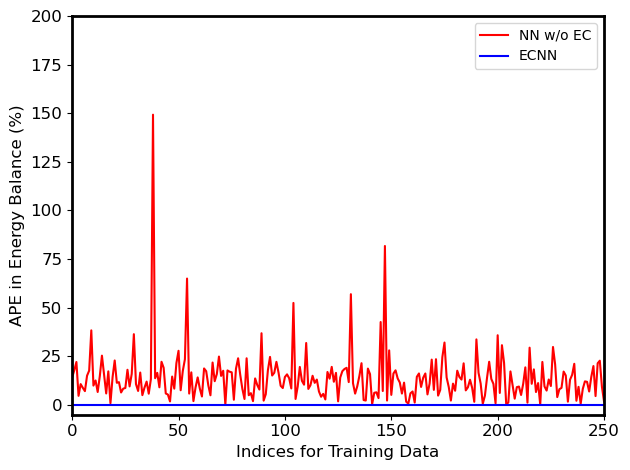

In [23]:
plt.rcParams.update(
    {
        "figure.max_open_warning": 0,
        "axes.titlesize": 16,
        "axes.labelsize": 12,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "savefig.bbox": "tight",
        "legend.fontsize": "medium",
    }
)

plt.plot(heat_bal_st_t_wo, color = 'red', linewidth = 1.5, label = 'NN w/o EC')
plt.plot(heat_bal_st_t_ecnn, color = 'blue', linewidth = 1.5, label = 'ECNN')
plt.xlim(0, 250)
plt.ylim(-5, 200)
plt.xlabel('Indices for Training Data')
plt.ylabel('APE in Energy Balance (%)')
plt.legend()

plt.tight_layout()
plt.show()